In [2]:
%matplotlib inline

import operator
import itertools
import numpy as np
import pandas as pd
from ggplot import *
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score

rcParams['figure.figsize'] = 15, 5

C:\Users\msharp\AppData\Local\Continuum\anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\msharp\AppData\Local\Continuum\anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\msharp\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data_train = pd.read_csv('examples/[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data_train[['title', 'groups', 'keywords', 'topics']]

In [5]:
print(len(data_train))
data_train.head()

398


,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...


In [6]:
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
data_train = data_train.join(s).reset_index()

In [8]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


In [10]:
def matrix_from_df(data_train):
    matrix = data_train.pivot_table(index = ['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix, x_cols

In [11]:
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5,1,'Elbow for KMeans clustering')

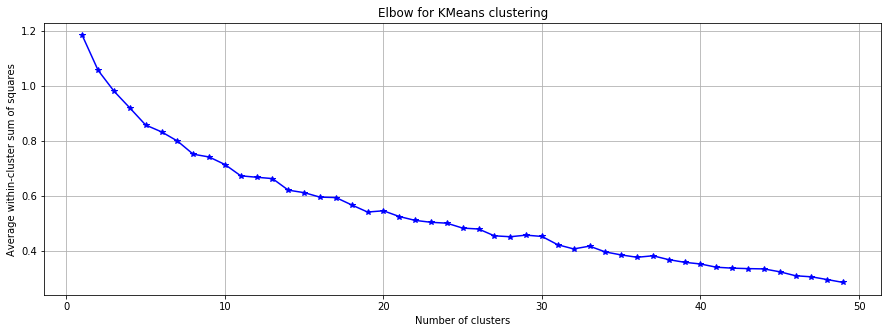

In [12]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

Text(0.5,1,'Elbow for KMeans clustering')

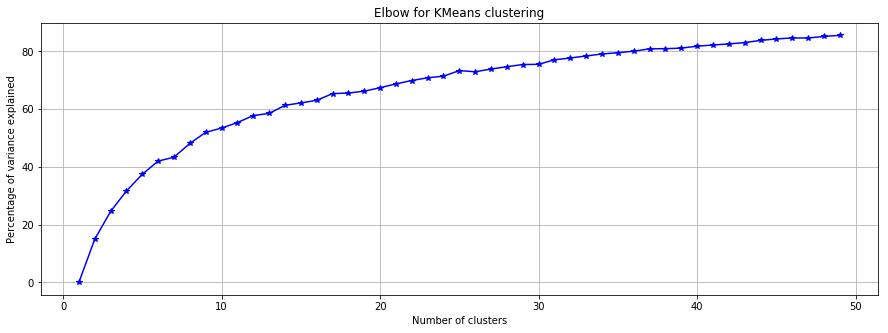

In [13]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]

wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

kIdx = 10-1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

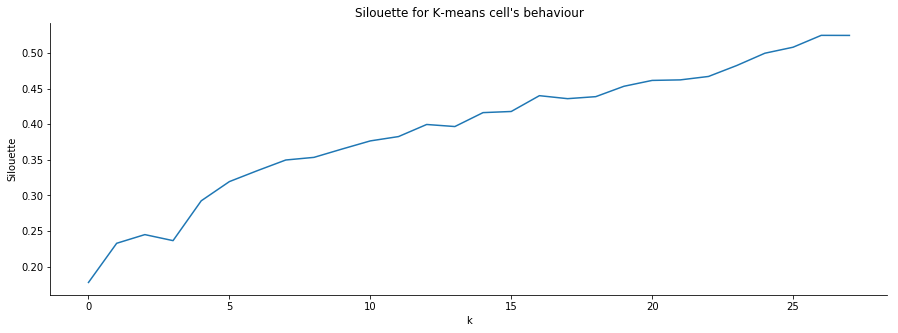

In [16]:
# Silhouette Score - The best value is 1 and the worst is -1. A coefficient value of 0 indicates overlapping clusters. 
s = []

for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(X, labels, metric='euclidean'))

plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

In [17]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

cluster = KMeans(n_clusters = 9, random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

0    81
1    78
5    44
3    38
6    36
2    32
8    30
7    30
4    27
Name: cluster, dtype: int64

In [18]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",1,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,8,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",4,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,2,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,3,0.198578,-0.129668


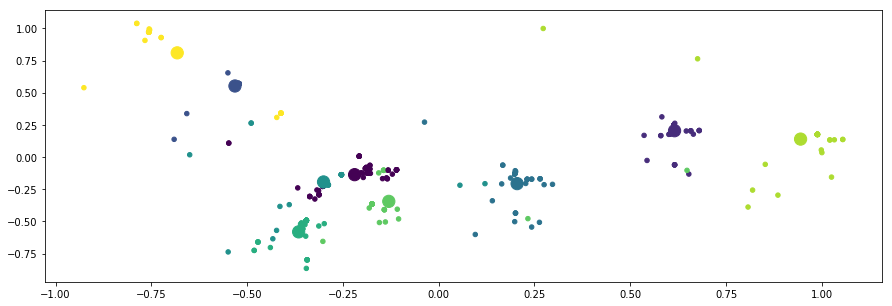

In [20]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

plt.scatter(customer_clusters['x'], customer_clusters['y'], s = 20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s = 150, c=cluster_centers['cluster'])

In [21]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')
df.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,1,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,2,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


In [23]:
def wordcloud_object(word_string):
    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT + 'arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

In [24]:
def plot_wordcloud(df, clusters, pivot):
    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List_ = []

        for x in df[df['cluster']==cluster][pivot]:
            try:
                 List_.extend(x.split('\n'))
            except:
                pass

        if List_:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

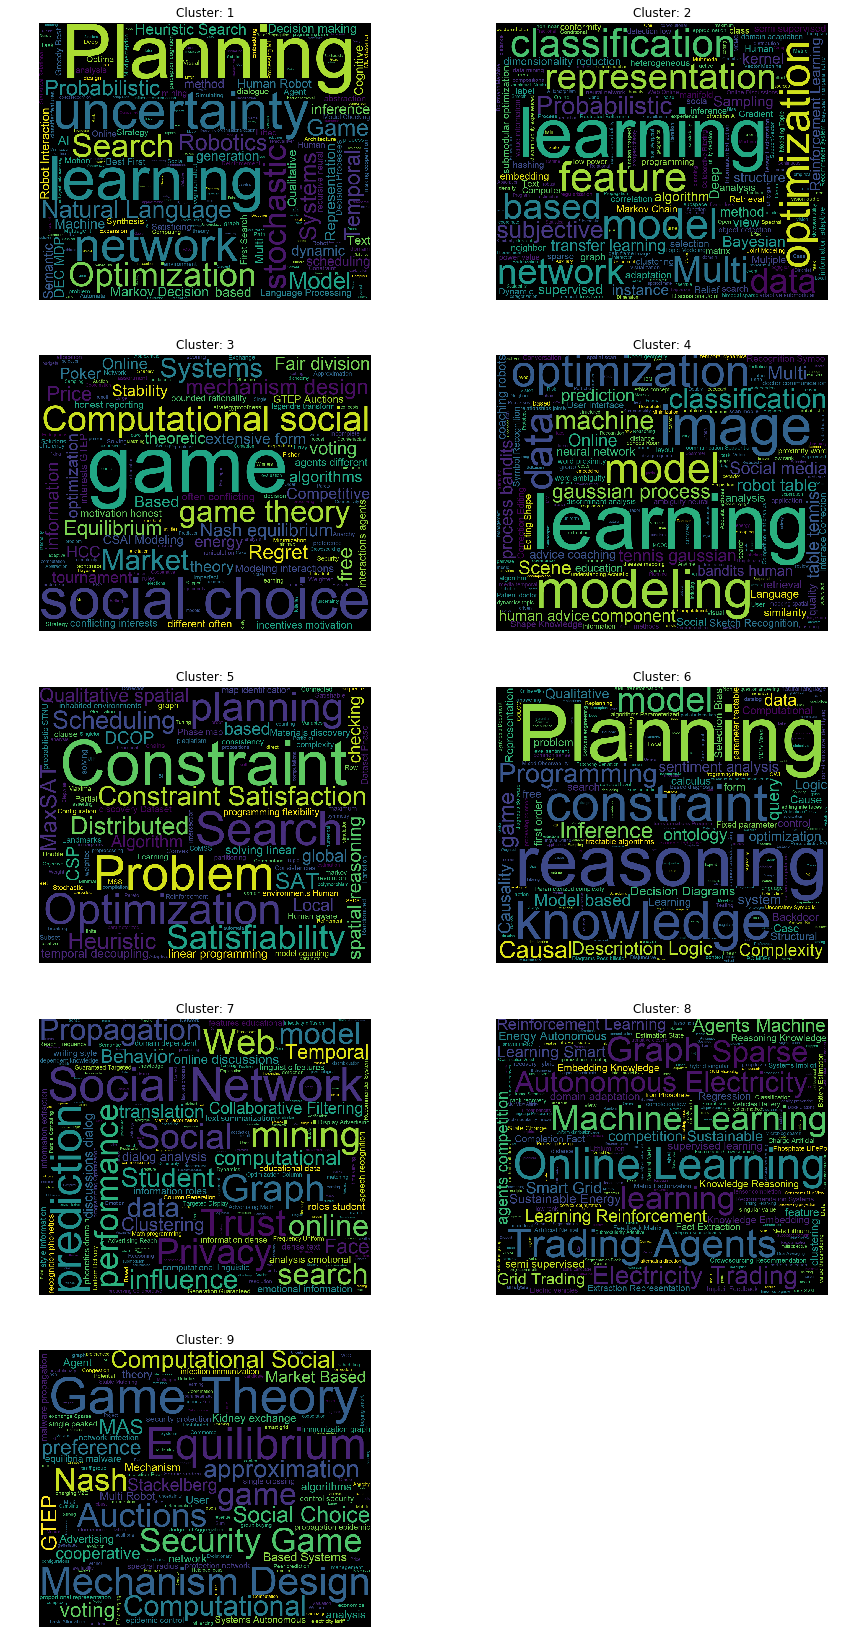

In [25]:
plot_wordcloud(df, cluster.n_clusters, 'keywords')